In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
from scipy import stats
from scipy import optimize

# Pricing

## Environment

In [2]:
class AdversarialPricingEnvironment_Logit:
    def __init__(self, max_price=1.0, noise_level=0):
        self.max_price = max_price
        self.noise_level = noise_level
        np.random.seed(42)

    def generate_data(self, n_points=100, beta_parameter=-5):
        prices = np.linspace(0, self.max_price, n_points)
        
        # Beta will be our parameter
        alpha = 1
        purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta_parameter * prices)))    
        
        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        
        # purchase probability in [0,1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities

    def simulate_jumps(self, mu = 4): # Default mu = 4 since it's the number of seasons (so we'll observe a year)
        # Jumps number from a Poisson with mean mu
        num_jumps = np.random.poisson(mu)
        
        # Jump lengths from an normal -> 90 is more or less one season lenght
        jump_lengths = np.round(np.random.normal(loc=90, scale=5, size=num_jumps)) 
        
        # Time Horizon
        T = int(jump_lengths.sum()) # So built you will se num_jums-1 effctivly jumps
        
        return num_jumps, jump_lengths, T

In [3]:
# Changes in the purchase probability function
def PurchaseProbabilityLogit_plot(beta_parameters, jump_days):
    n_points = 100
    prices = np.linspace(0, 1, n_points)
    alpha = 1
    
    # Calcola il numero totale di subplot
    num_subplots = len(jump_days)
     
    # Crea la figura e gli assi dei subplot
    fig, axes = plt.subplots(1, num_subplots, figsize=(20, 5))
    axes = axes.flatten() 
    
    for i, jump_day in enumerate(jump_days):
        # Calcola le probabilità di acquisto usando il corrispondente beta_parameter per l'indice jump_day
        purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta_parameters[int(jump_day)] * prices)))    
        
        # Traccia il grafico
        ax = axes[i]
        ax.plot(prices, purchase_probabilities)
        ax.set_title(f'Beta Parameter: {beta_parameters[int(jump_day)]}')
        ax.set_xlabel('Prices')
        ax.set_ylabel('Purchase Probabilities')

    # Aggiusta il layout
    plt.tight_layout()
    plt.show()

## UCB1 agent

In [4]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

# Advertising

## Environment

In [5]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [6]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, winners_values, bids): # Little change, here I pass directly 'winners_values', instead of 'values' and then 'values[winners]' 
        payments = winners_values/self.ctrs[winners] # Publisher entries
        return payments.round(2)

    def simulate_jumps(self, mu_pois = 3, mu_norm = 10000):
        jum_num = np.clip(np.random.poisson(mu_pois), 1, 10)
        users_num_between_jumps = np.round(np.random.normal(mu_norm, 25, size = jum_num))

        total_users = int(users_num_between_jumps.sum())

        return jum_num, users_num_between_jumps, total_users
        

## FFMultipliclative Pacing agent

In [7]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [8]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

# Interaction

In [9]:
# LOAD PRICING DATA
file_path = "PricingData/Logit_S=2_Decreasing.npz"

data = np.load(file_path)
prices_matrix = data['prices_matrix']
probabilities_matrix = data['probabilities_matrix']
beta_parameters = data['beta_parameters']
jump_days = data['jump_days']

# Customers and rewards cannot be loaded, since they will depends on the advertising campaign.

print(f"Matrices loaded from {file_path}")

Matrices loaded from PricingData/Logit_S=2_Decreasing.npz


In [10]:
# PARAMETERS
n_points = 100  # actions number 
cost = 0.2
n_customers = np.array([np.round(np.random.normal(200, 25, size = 3)).sum()]) # initialization
max_price = 1.0
my_valuations = np.array([])

K = n_points
T = prices_matrix.shape[0]
n_days = prices_matrix.shape[0]

prices = np.linspace(0, max_price, n_points)

users_each_day = np.array([]) # Store the total number of users(i.e. auctions) visiting the webpage each day


# DATA STILL TO DERIVED (PRICING) 
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))
# DATA STILL TO DERIVED (ADVERTISING)
advertising_all_regrets = []
advertising_all_payments = []
advertising_all_utilities = []
advertising_all_clairvoyant = []


# INTERACION LOOP
# Pricing agent
ucb_agent = UCB1Agent(K, T, range=1)
agent_rewards = np.array([])
for day in range(n_days):

# CUSTOMER AND REWARD ROW FOR THAT DAY 
    n_customer = n_customers[-1]
    for j in range(n_points):
            customers_number_matrix[day, j] = np.random.binomial(n_customer, probabilities_matrix[day, j])
            rewards_matrix[day, j] = customers_number_matrix[day, j]*(prices[j] - cost)


# PRICING AGENT SELECTS THE PRICE
    pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
    p_t = prices[pi_t] # PRICE that has to be pass ( - cost ) to the advertising part
    r_t = rewards_matrix[day, pi_t]
    ucb_agent.update(r_t)

    agent_rewards = np.append(agent_rewards, r_t)

  
    
# SET THE 'MY VALUATION' FOR THAT DAY
    my_valuation = p_t - cost
    my_valuations = np.append(my_valuations, my_valuation)



# ADVERTISING CAMPAIGN    
    # OTHER BIDDERS
    # publisher's fixed parameters
    n_slots = 3
    lmbd = np.array([1, 1, 1]) # case in which all the slots are equivalent

    # advertisers' fixed parameters
    n_adv = 4 # four other advertisers, our agent not included
    ctrs = np.ones(n_adv+1)
    #v = np.array([0.7, 1.1, 1.4, 0.85])

    std_bid = 0.05
    mu_parameters = np.array([0.5]) # starting value for beta is -5
    S_auction =  0.1# Varianace of the Normal for the beta_parameter variations during shock days 
    s_auction = 0.0001

    auction = GeneralizedFirstPriceAuction(ctrs=ctrs, lambdas=lmbd)
    # environmental settings
    jum_num, users_num_between_jumps, n_users = auction.simulate_jumps()
    jump_users = np.cumsum(users_num_between_jumps)

    users_each_day = np.append(users_each_day, n_users)


    B = 2000 # Let's try to fix it
    rho = B/n_users

    
    other_bids = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)


    for u in range(n_users):
        if u in jump_users:
            mu_variation = np.random.normal(0, S_auction)
            mu_parameter = mu_parameters[-1] +  mu_variation

        else:
            mu_variation = np.random.normal(0, s_auction)
            mu_parameter = mu_parameters[-1] +  mu_variation

        mu_parameters = np.append(mu_parameters, mu_parameter)

        other_bids_daily = np.clip(np.random.normal(mu_parameters[-1], std_bid, size=(n_adv, 1)), 0, 1)
        other_bids = np.append(other_bids, other_bids_daily, axis=1)

    available_bids = np.linspace(0,my_valuation,100)
    m_t = np.sort(other_bids, axis=0)[-n_slots] 
    win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

    
    # CLAIRVOYANTS
    c = -(my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

    advertising_all_clairvoyant.append(np.cumsum(expected_clairvoyant_utilities))


    
    # MY AGENT
    eta = 1/np.sqrt(n_users) # from theory
    FFMP_agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)


    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0

    np.random.seed(1)
    for u in range(n_users):
        # interaction
        my_bid = FFMP_agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(0 in winners) # change, here we have more than one winner, so it's sufficient that I (index 0) am between them
        f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
        FFMP_agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins+=my_win # This will be the number of customers for the next day in the pricing part (actually for the day itself but we've already initialize that value, so let's think about it as for the nex day) 
        
    advertising_all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    advertising_all_payments.append(np.cumsum(my_payments))
    advertising_all_utilities.append(np.cumsum(utilities))


# CONCATENATE THE NEW CUSTOMER NUMBER
    n_customers = np.append(n_customers, total_wins)        

## Pricing analysis

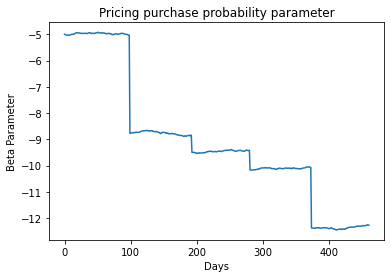

Beta: -5.032249625883139
Beta: -8.840827349932788
Beta: -9.411734501719117
Beta: -10.069526520592861
Beta: -12.264926339220604


In [11]:
# # History of the beta parameter
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),beta_parameters)
plt.title('Pricing purchase probability parameter')
plt.xlabel('Days')
plt.ylabel('Beta Parameter')

plt.show()

# Values of beta in the jumps
for jump_day in jump_days:
    print(f'Beta: {beta_parameters[int(jump_day)]}')

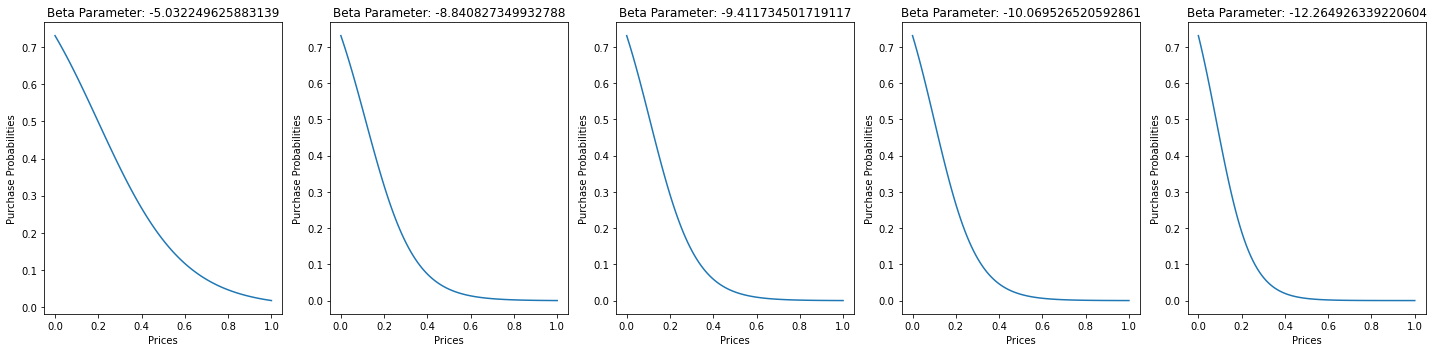

In [12]:
# Plot of the purchase probability when beta jumps
PurchaseProbabilityLogit_plot(beta_parameters, jump_days)

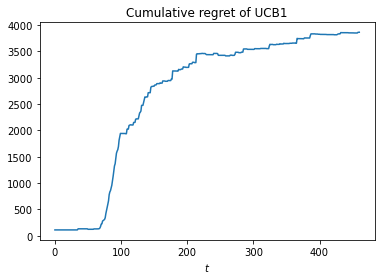

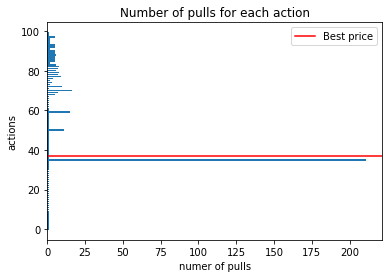

In [26]:
# Pricing regret where the clairvoyants rewards are computed after the whole simulation, so in hinsdisght
best_arm_index = np.argmax(rewards_matrix.sum(axis=0))
best_arm = prices[best_arm_index]
clairvoyant_rewards = rewards_matrix[:, best_arm_index]

cumulative_regret = np.cumsum(clairvoyant_rewards-agent_rewards)


plt.plot(np.arange(T), cumulative_regret)
plt.title('Cumulative regret of UCB1')
plt.xlabel('$t$')
#plt.savefig('RegretPricing_Interaction.png')
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

## Advertising analysis

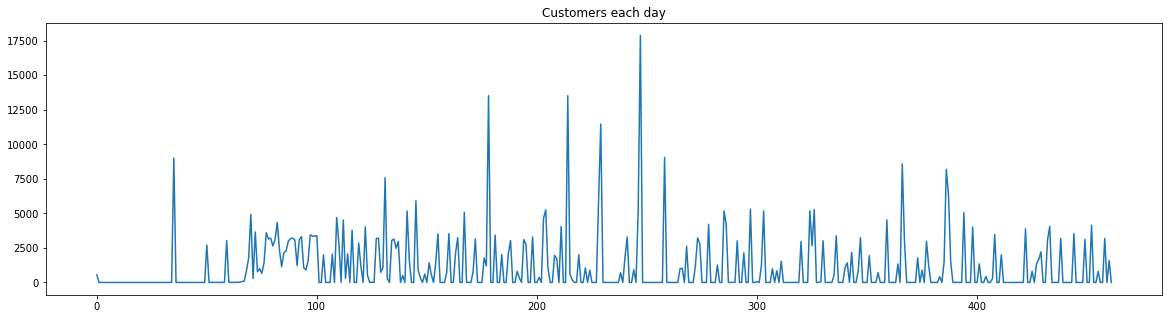

In [14]:
# Customers number each day (i.e. the number of won auctions each day)
plt.figure(figsize=(20, 5))
plt.plot(np.arange(T+1), n_customers)
plt.title('Customers each day')
plt.show()

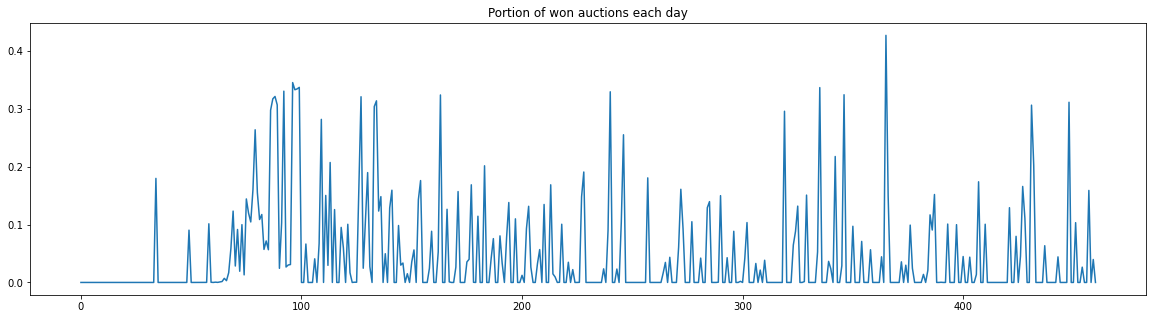

In [15]:
# Portion of won auctions each day
plt.figure(figsize=(20, 5))
plt.plot(np.arange(T), n_customers[1:]/users_each_day)
plt.title('Portion of won auctions each day')
plt.show()

In [16]:
# Min/Max lenght, i.e. the lowest/highest number of auctions
min_length = min(len(regret) for regret in advertising_all_regrets)
max_length = max(len(regret) for regret in advertising_all_regrets)

# Reduced utilities list, i.e. taking only the firts 'min_legth' users each day
advertising_all_utilities_reduced = []
for utility in advertising_all_utilities:
    advertising_all_utilities_reduced.append(utility[:min_length])

# Filled utilities list, i.e. filing with 'Nan' up to 'max_length' if in that day there are less than 'max_length' auctions
padded_utilities = []
for utility in advertising_all_utilities:
    padded = np.pad(utility, (0, max_length - len(utility)), 'constant', constant_values=np.nan)
    padded_utilities.append(padded)

# Reduced regrets list, i.e. taking only the firts 'min_legth' users each day
advertising_all_regrets_reduced = []
for regret in advertising_all_regrets:
    advertising_all_regrets_reduced.append(regret[:min_length])

# Filled regrets list, i.e. filing with 'Nan' up to 'max_length' if in that day there are less than 'max_length' auctions
padded_regrets = []
for regret in advertising_all_regrets:
    padded = np.pad(regret, (0, max_length - len(regret)), 'constant', constant_values=np.nan)
    padded_regrets.append(padded)

# Reduced payments list, i.e. taking only the firts 'min_legth' users each day
advertising_all_payments_reduced = []
for payment in advertising_all_payments:
    advertising_all_payments_reduced.append(payment[:min_length])

# Filled payments list, i.e. filing with 'Nan' up to 'max_length' if in that day there are less than 'max_length' auctions
padded_payments = []
for payment in advertising_all_payments:
    padded = np.pad(payment, (0, max_length - len(payment)), 'constant', constant_values=np.nan)
    padded_payments.append(padded)

In [17]:
# Same but with the clairvoyant
# Reduced utilities list, i.e. taking only the firts 'min_legth' users each day
advertising_all_clairvoyant_reduced = []
for utility in advertising_all_clairvoyant:
    advertising_all_clairvoyant_reduced.append(utility[:min_length])

# Filled utilities list, i.e. filing with 'Nan' up to 'max_length' if in that day there are less than 'max_length' auctions
padded_clairvoyant_utilities = []
for utility in advertising_all_clairvoyant:
    padded = np.pad(utility, (0, max_length - len(utility)), 'constant', constant_values=np.nan)
    padded_clairvoyant_utilities.append(padded)

In [18]:
# Mean/Std reduced and full (excluding Nan)
avg_regret_reduced = np.mean(np.array(advertising_all_regrets_reduced), axis=0)
std_regret_reduced = np.std(np.array(advertising_all_regrets_reduced), axis=0)

avg_regret_filled = np.nanmean(np.array(padded_regrets), axis = 0)
std_regret_filled = np.nanstd(np.array(padded_regrets), axis = 0)

avg_payment_reduced = np.mean(np.array(advertising_all_payments_reduced), axis=0)
std_payment_reduced = np.std(np.array(advertising_all_payments_reduced), axis=0)

avg_payment_filled = np.nanmean(np.array(padded_payments), axis = 0)
std_payment_filled = np.nanstd(np.array(padded_payments), axis = 0)

avg_utility_reduced = np.mean(np.array(advertising_all_utilities_reduced), axis=0)
std_utility_reduced = np.std(np.array(advertising_all_utilities_reduced), axis=0)

avg_utility_filled = np.nanmean(np.array(padded_utilities), axis = 0)
std_utility_filled = np.nanstd(np.array(padded_utilities), axis = 0)

avg_clairvoyant_reduced = np.mean(np.array(advertising_all_clairvoyant_reduced), axis=0)
std_clairvoyant_reduced = np.std(np.array(advertising_all_clairvoyant_reduced), axis=0)

avg_clairvoyant_filled = np.nanmean(np.array(padded_clairvoyant_utilities), axis = 0)
std_clairvoyant_filled = np.nanstd(np.array(padded_clairvoyant_utilities), axis = 0)

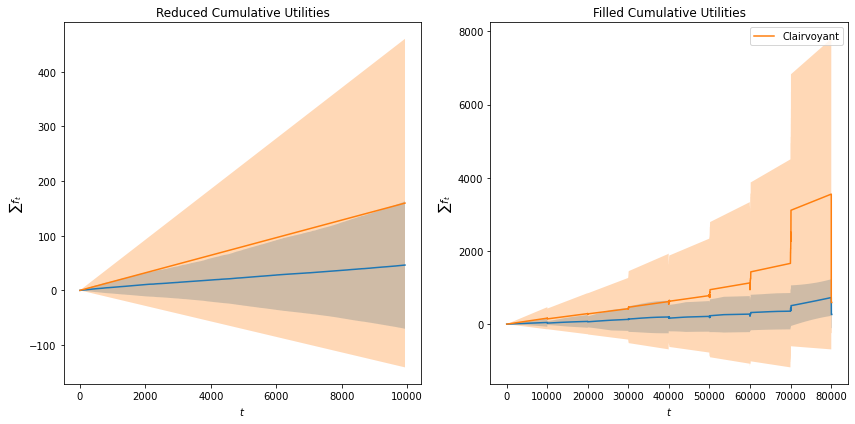

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(np.arange(min_length), avg_utility_reduced)
ax1.fill_between(np.arange(min_length), avg_utility_reduced-std_utility_reduced, avg_utility_reduced+std_utility_reduced, alpha=0.3)
ax1.plot(np.arange(min_length), avg_clairvoyant_reduced, label = 'Clairvoyant')
ax1.fill_between(np.arange(min_length), avg_clairvoyant_reduced-std_clairvoyant_reduced, avg_clairvoyant_reduced+std_clairvoyant_reduced, alpha=0.3)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\sum f_t$')
ax1.set_title('Reduced Cumulative Utilities')

ax2.plot(np.arange(max_length), avg_utility_filled)
ax2.fill_between(np.arange(max_length), avg_utility_filled-std_utility_filled, avg_utility_filled+std_utility_filled, alpha=0.3)
ax2.plot(np.arange(max_length), avg_clairvoyant_filled, label = 'Clairvoyant')
ax2.fill_between(np.arange(max_length), avg_clairvoyant_filled-std_clairvoyant_filled, avg_clairvoyant_filled+std_clairvoyant_filled, alpha=0.3)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$\sum f_t$')
ax2.set_title('Filled Cumulative Utilities')

plt.tight_layout()
plt.legend()
plt.show()

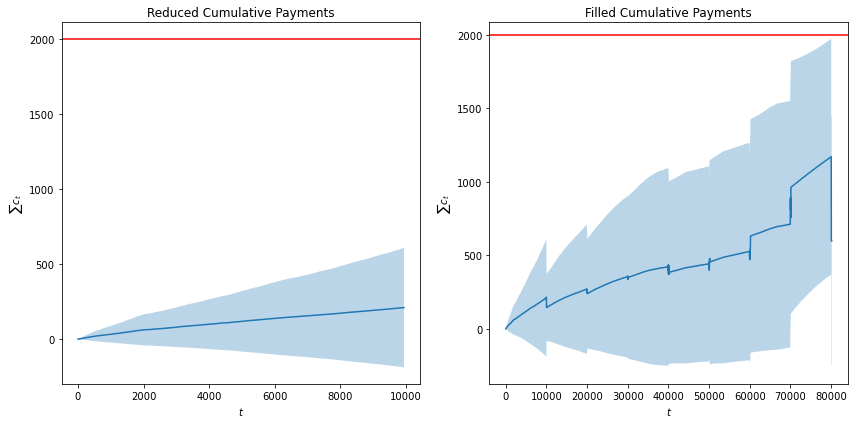

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(np.arange(min_length), avg_payment_reduced)
ax1.fill_between(np.arange(min_length), avg_payment_reduced-std_payment_reduced, avg_payment_reduced+std_payment_reduced, alpha=0.3)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\sum c_t$')
ax1.axhline(B, color='red', label='Budget')
ax1.set_title('Reduced Cumulative Payments')

ax2.plot(np.arange(max_length), avg_payment_filled)
ax2.fill_between(np.arange(max_length), avg_payment_filled-std_payment_filled, avg_payment_filled+std_payment_filled, alpha=0.3)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$\sum c_t$')
ax2.axhline(B, color='red', label='Budget')
ax2.set_title('Filled Cumulative Payments')

plt.tight_layout()
plt.show()

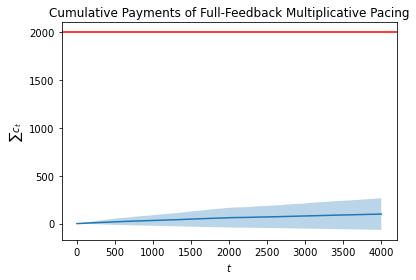

In [21]:
# For the presentation we could keep only the nicest part of the filled paymenet plot
plt.plot(np.arange(4000), avg_payment_filled[:4000])
plt.fill_between(np.arange(4000), avg_payment_filled[:4000]-std_payment_filled[:4000], avg_payment_filled[:4000]+std_payment_filled[:4000], alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.title('Cumulative Payments of Full-Feedback Multiplicative Pacing')
plt.show()

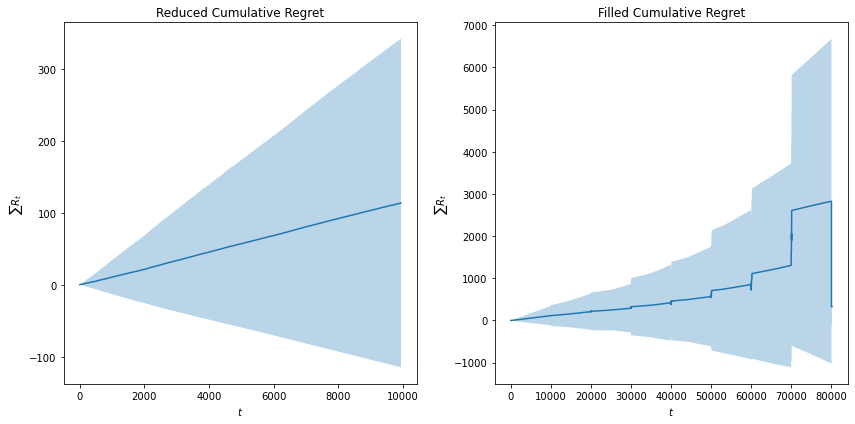

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(np.arange(min_length), avg_regret_reduced)
ax1.fill_between(np.arange(min_length), avg_regret_reduced-std_regret_reduced, avg_regret_reduced+std_regret_reduced, alpha=0.3)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\sum R_t$')
ax1.set_title('Reduced Cumulative Regret')

ax2.plot(np.arange(max_length), avg_regret_filled)
ax2.fill_between(np.arange(max_length), avg_regret_filled-std_regret_filled, avg_regret_filled+std_regret_filled, alpha=0.3)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$\sum R_t$')
ax2.set_title('Filled Cumulative Regret')

plt.tight_layout()
plt.show()

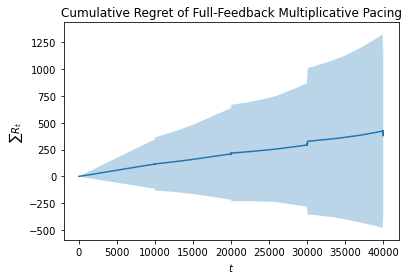

In [25]:
# For the presentation we could keep only the nicest part of the filled regret plot
plt.plot(np.arange(40000), avg_regret_filled[:40000])
plt.fill_between(np.arange(40000), avg_regret_filled[:40000]-std_regret_filled[:40000], avg_regret_filled[:40000]+std_regret_filled[:40000], alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
#plt.savefig('RegretAdvertising_Interaction.png')
plt.show()

Regrets and payments are plotted averaging on all the days of the interaction, even if we declare a new advertising agent every day.
The mean and std computation is done 2 different ways:
- one using data up to the minimum number of customers among all the days of the interaction; here every advertising agent can give his contribute in the comutation of the average and the std
- the other go ahead until the longest advertising campaign is ended, inserting 'Nan' in all the missing values due to shortest campaign.

Probably the last part of the second tipe of plot shows a strange behavoir since it takes into account only few agents, the ones correspondent to those few days with an high number of customers; at the same time also the first type of plot is not enough, since it ends after 140 customers, when instead the highest number of them is almost 1500.  
Thus a possible plpot for the presentation could be a reduction of the sencond type of plot, maybe going ahead up to 1000 customers.